## Predicting

**Importing librairies**


In [127]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import shuffle
import geopandas as gpd
from tqdm import tqdm

**Denne nettsiden snakker litt om hvordan jobbe med ubalanserte datasett**

https://medium.com/digital-catapult/dealing-with-imbalanced-data-8b21e6deb6cd

**Importing data**

In [128]:
Filename = "data\_tarefelt1.csv"
data = pd.read_csv(Filename)


In [129]:
#Removes 90% of data labeled 0
data = data.drop(data[data['label'] == 0].sample(frac=.95).index)

In [130]:
data_x = data.drop(columns = "label")
data_x = data.drop(columns = "geometry")
data_y = data.label

In [250]:
scaler = StandardScaler()
scaler.fit(data_x) 
scaled_data_x = scaler.transform(data_x)
data_x = pd.DataFrame(scaled_data_x, index= data_x.index, columns=data_x.columns)


**Splitting Data**

In [131]:
X_train, X_test ,y_train, y_test = train_test_split( data_x, data_y, test_size=0.30, random_state=42)
X_test, X_val ,y_test, y_val = train_test_split( X_test, y_test, test_size=0.5, random_state=42)

**Definerer en batch generator**

In [132]:
def batch(iterable_X, iterable_y, n=1):
    '''
    n: batchsize
    iterable_X: X frame to be iterated over
    iterable_y: y frame to be iterated over
    '''
    l = len(iterable_X)
    for ndx in range(0, l, n):
        yield iterable_X[ndx:min(ndx + n, l)], iterable_y[ndx:min(ndx + n, l)]


In [180]:
""" scaler = StandardScaler()
scaler.fit(X_train) 
scaled_X_train = scaler.transform(X_train)
X_train = pd.DataFrame(scaled_X_train, index= X_train.index, columns=X_train.columns)
scaled_X_test = scaler.transform(X_test)
X_test  = pd.DataFrame(scaled_X_test, index= X_test.index, columns=X_test.columns)
scaled_X_val = scaler.transform(X_val)
X_val  = pd.DataFrame(scaled_X_val, index= X_val.index, columns=X_val.columns) """

**Training the model**  


In [242]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
clf = SGDClassifier(max_iter=1000, tol=1e-3, class_weight= dict(zip(np.unique(y_train), class_weights)))


classes = np.unique(y_train)
accuracy =[]
ROUNDS = 200
batch_size = 10000
for _ in tqdm(range(ROUNDS), desc=" outer", position=0, total=ROUNDS):
    #X_train, y_train = shuffle(X_train, y_train)
    batcherator = batch(X_train, y_train, batch_size)
    
    for index, (X, target) in tqdm(enumerate(batcherator), desc=" inner loop",position=1, leave=True, total=70):

        #scaler = StandardScaler()
        #scaler.fit(X) 
        #X = scaler.transform(X)
        #test = scaler.transform(X_val) 
        clf.partial_fit(X, target, classes)
        y_predicted = clf.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_predicted))

 outer: 100%|██████████| 200/200 [00:31<00:00,  6.26it/s]


**Evaluating Model**


[[7072    0]
 [   0 8086]]


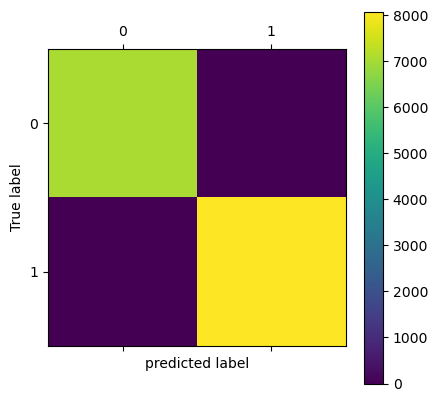

In [243]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_predicted)

print(conf_mat)
# Plot matrix
plt.matshow(conf_mat)
plt.colorbar()
plt.ylabel("True label")
plt.xlabel("predicted label")
plt.show()

**Checking over the test set**

In [246]:
y_predicted = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_predicted)
print(f"The accuracy of the model was {np.round(accuracy,2)}")

The accuracy of the model was 0.47


In [247]:
np.count_nonzero(y_predicted)

0

In [248]:
unique, counts = np.unique(y_predicted, return_counts=True)


In [249]:
print(unique)
print(counts)

[0.]
[15158]


In [219]:
X_test

,Unnamed: 0,band_0,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,...,band_59,band_60,band_61,band_62,band_63,band_64,band_65,lat,lon,label
304290,-0.146121,0.0,0.0,0.0,-0.199614,-0.172480,-0.171667,-0.196963,-0.199796,-0.211136,...,0.249879,0.547020,-0.009171,-0.138507,-0.232175,0.202288,0.034472,0.794264,0.471694,0.939830
163729,-0.677945,0.0,0.0,0.0,-0.278093,-0.311427,-0.285135,-0.066120,-0.229157,-0.266033,...,0.344149,-0.105782,0.056444,1.178066,-0.094814,-0.187215,0.092080,-0.763120,0.429262,0.939830
229137,-0.430469,0.0,0.0,0.0,4.106005,4.110533,4.104008,4.086445,4.135874,4.091279,...,1.852465,2.039685,1.992063,0.467657,0.348966,0.638676,-0.500002,1.200496,0.938975,0.939830
307209,-0.135077,0.0,0.0,0.0,-0.233503,-0.216091,-0.178114,-0.205571,-0.234051,-0.233467,...,-0.060219,0.096548,-0.021473,-0.478267,-0.619602,-0.800321,-0.160755,1.056328,0.563418,-1.064022
211188,-0.498380,0.0,0.0,0.0,3.161587,3.096322,2.870045,2.814163,2.940221,3.170130,...,0.527727,0.890600,0.138461,0.015930,-0.450543,-0.183608,-0.717631,1.017763,0.939947,0.939830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282676,-0.227899,0.0,0.0,0.0,-0.286119,-0.267816,-0.299318,-0.336415,-0.335184,-0.277199,...,-0.472029,-0.289025,-0.173206,-1.265894,-1.658611,-0.208854,-1.095283,-0.462930,0.062684,-1.064022
97717,-0.927707,0.0,0.0,0.0,-0.278093,-0.315484,-0.283845,-0.317477,-0.297667,-0.244633,...,-1.027725,-0.334836,0.220479,-0.292943,0.348966,0.379007,-0.743235,-0.797387,0.685037,-1.064022
201911,-0.533480,0.0,0.0,0.0,-0.315548,-0.253617,-0.348316,-0.310591,-0.251994,-0.288364,...,-0.042853,0.604284,0.630568,0.371134,0.264436,0.660315,0.783374,-1.302691,0.060093,0.939830
823643,1.818894,0.0,0.0,0.0,-0.250447,-0.327655,-0.290292,-0.214180,-0.141074,-0.255798,...,-0.082546,-0.143958,-0.382352,0.421326,1.278791,-1.193431,-0.580013,0.237665,-1.867415,-1.064022


In [224]:
y_test.value_counts()


1.0    8086
0.0    7072
Name: label, dtype: int64

**Plotting the predicted seaweed and comparing with naturdirektoratet**

In [222]:
X = X_test.copy()
X["label"] = y_test
X["y_predicted"] = y_predicted
X = gpd.GeoDataFrame(X, geometry=gpd.points_from_xy(X.lon, X.lat))

df_no_seaweed = X[X["y_predicted"] == False].copy()
df_seaweed = X[X["y_predicted"] == True].copy()
df_true_seaweed = X[X["label"] == True].copy()

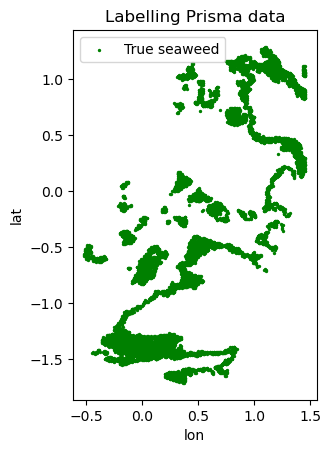

In [223]:
fig, ax = plt.subplots()
#df_no_seaweed.plot(ax = ax, color = "blue", label = "no seaweed")
df_true_seaweed.plot(ax = ax, color = "green", label = "True seaweed", markersize = 2)
df_seaweed.plot(ax = ax, color = "red", label = "Seaweed", markersize = 1)

ax.set_title("Labelling Prisma data")
ax.set_xlabel("lon")
ax.set_ylabel("lat")
ax.legend()